In [1]:
import pickle
import math
from datetime import timedelta

import pandas as pd
import numpy as np
import plotly.express as px

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

from config import SQLQuery

import warnings
warnings.filterwarnings("ignore")

In [2]:
querySno = SQLQuery('snowflake')

In [3]:
# fraud = querySno(
# """
# with funded_accounts_tmp as (
# select distinct a.BUSINESS_ID, a.APPLICATION_ID, DATEDIFF(day, ACCOUNT_CREATE_DATE, TRANSACTION_DATE) as DAYS_SINCE_CREATED from 
# (
#   select distinct APPLICATION_ID, BUSINESS_ID, ACCOUNT_CREATE_DATE from "PROD_DB"."DATA"."BUSINESSES"
#   where ACCOUNT_CREATE_DATE between '2021-01-01' and '2022-02-28'
# ) a
# inner join
# (
#   select distinct BUSINESS_ID, TRANSACTION_DATE from "PROD_DB"."DATA"."TRANSACTIONS" where type='credit' and status='active'
# ) b
# on a.BUSINESS_ID=b.BUSINESS_ID
# where a.APPLICATION_ID is not null and DAYS_SINCE_CREATED between  0 and 60
# ),

# funded_accounts as (
# select distinct BUSINESS_ID, APPLICATION_ID from funded_accounts_tmp
# ),

# loss_tx as (
#        select *
#         from (
#             select business_id
#             , RANK() OVER (PARTITION BY business_id
#                 ORDER BY transaction_date DESC) returned_rank
#             , amount as loss_tx_amount
#             , created_date loss_tx_created_at
#             , transaction_date loss_tx_transaction_date
#             from prod_db.data.transactions
#             where 1=1
#                 and medium in ('Descriptive Deposit', 'Closeout Withdrawal')
#                 and amount > 0
#                 and running_balance = 0
#         )
#         where returned_rank=1
# ),

# fraud_closure_accounts as (
#     select business_id, closure_reason, business_type, account_close_date, ACCOUNT_CREATE_DATE 
#     ,ACCOUNT_STATUS, CLOSURE_IS_SUSPECT_FRAUD
#     from prod_db.data.businesses 
#     where 1=1
#         and closure_reason ilike '%fraud%' 
#         and account_close_date is not null 
#         and ACCOUNT_CREATE_DATE between '2021-01-01' and '2022-02-28'
#         and account_close_date between '2021-01-01' and '2022-02-28'
# ),

# fraud_acounts_less_60 as (
# select distinct f.business_id, 1 as fraud from (
# select * from fraud_closure_accounts where datediff(day, ACCOUNT_CREATE_DATE, coalesce(account_close_date, current_date())) <= 60
# ) f 
# inner join loss_tx l on f.business_id = l.business_id
# ),

# fraud_acounts_greater_60 as (
# select distinct f.business_id, 1 as fraud from (
# select * from fraud_closure_accounts where datediff(day, ACCOUNT_CREATE_DATE, coalesce(account_close_date, current_date())) > 60
# ) f 
# inner join loss_tx l on f.business_id = l.business_id
# ),

# distinct_app_id_tmp1 as (
# select distinct 
# a.business_id, a.APPLICATION_ID,
# case 
#     when b.fraud=1 then 1
#     else 0
# end as fraud 
# from funded_accounts a
# left join
# fraud_acounts_less_60 b
# on a.business_id=b.business_id
# ),

# distinct_app_id as (
# select a.* from distinct_app_id_tmp1 a
# left join
# fraud_acounts_greater_60 b
# on a.business_id=b.business_id 
# where b.business_id is null
# )

# select * from distinct_app_id 

# """)


In [4]:
fraud_path = '../data/raw/fraud.pkl'
# fraud.to_pickle(fraud_path)
fraud = pd.read_pickle(fraud_path)

In [5]:
fraud.shape

(110243, 3)

In [125]:
fraud['fraud'].value_counts()

0    109772
1       471
Name: fraud, dtype: int64

In [17]:
len(np.unique(list(fraud['business_id'])))

110243

In [7]:
471*100/110243

0.42723801057663524

### Applications Features 

In [12]:
# app_data = querySno(
# """
# select
# APPLICATION_ID,
# IS_EMAIL_VALID,
# EMAIL_IS_VERIFIED,
# AZLO_REFERRAL,
# APPLICATION_START_DATETIME,
# APPLICATION_COMPLETE_DATETIME,
# APPLICATION_RESUBMITTED_DATETIME,
# NUMBER_INCOMPLETE_EVENTS,
# AML_RISK_SCORE,
# HIGH_RISK_INDUSTRY,
# UTM_SOURCE,
# UTM_MEDIUM,
# APPLICATION_CHANNEL,
# ESTIMATED_MONTHLY_REVENUE,
# INCOMING_ACH_PAYMENTS,
# CHECK_DEPOSIT_AMOUNT,
# INCOMING_WIRE_TRANSFER,
# OUTGOING_ACH_AND_CHECKS,
# OUTGOING_WIRE_TRANSFERS,
# NUMBER_OF_EMPLOYEES,
# HAS_INTERNATIONAL_BUSINESS,
# LEGAL_NAME_EXIST_IN_DOC,
# HEAR_ABOUT_NOVO,
# INDUSTRY_CATEGORY_ID,
# INDUSTRY_CATEGORY_NAME,
# DATE_OF_ESTABLISHMENT,
# BUSINESS_TYPE
# from prod_db.data.applications 
# where ACCOUNT_OPENED_DATETIME between '2021-01-01' and '2022-02-28'
# """
# )

In [9]:
app_data.shape

(143800, 27)

In [10]:
len(np.unique(list(app_data['application_id'])))

143800

In [13]:
app_path = '../data/raw/applications.pkl'
# app_data.to_pickle(app_path)
app_data = pd.read_pickle(app_path)

In [14]:
fraud_app_data = pd.merge(fraud, app_data, on='application_id')

In [15]:
# After joining, there is a decrease of 196 records and ignoring now becoz all these records belongs to good customers
len(pd.unique(fraud_app_data['application_id']))

110047

In [18]:
fraud_app_data.shape

(110047, 29)

In [19]:
fraud_app_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110047 entries, 0 to 110046
Data columns (total 29 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   business_id                       110047 non-null  object        
 1   application_id                    110047 non-null  object        
 2   fraud                             110047 non-null  int64         
 3   is_email_valid                    110047 non-null  object        
 4   email_is_verified                 110047 non-null  bool          
 5   azlo_referral                     110047 non-null  bool          
 6   application_start_datetime        110047 non-null  datetime64[ns]
 7   application_complete_datetime     109982 non-null  datetime64[ns]
 8   application_resubmitted_datetime  32938 non-null   datetime64[ns]
 9   number_incomplete_events          110047 non-null  int64         
 10  aml_risk_score                  

In [54]:
cat_columns = ['is_email_valid','email_is_verified','azlo_referral',
               'application_channel','estimated_monthly_revenue',
               'incoming_ach_payments',
              'check_deposit_amount','incoming_wire_transfer','outgoing_ach_and_checks','outgoing_wire_transfers',
              'has_international_business','legal_name_exist_in_doc','hear_about_novo',
               'industry_category_name','business_type'
              ]
del_columns = ['application_resubmitted_datetime','utm_source','utm_medium','industry_category_id', 
               'number_incomplete_events']

In [276]:
def plotting_percentages(df, col, target):
    """
    This function plots the distribution of target with a variable
    Input:
        df: Dataframe with all the variables
        col: column name or variable name
        target: The target variable
    
    Output: The bar plot with distribution 
    """
    x, y = col, target
    
    # Temporary dataframe with percentage values
    temp_df = df.groupby(x)[y].value_counts(normalize=True)
    temp_df = temp_df.mul(100).rename('percent').reset_index()

    # Sort the column values for plotting    
    order_list = list(df[col].unique())
    try:
        order_list.sort()
    except:
        order_list = order_list

    # Plot the figure
    sns.set(font_scale=1.2)
    g = sns.catplot(x=x, y='percent', hue=y,kind='bar', data=temp_df, 
                    height=8, aspect=3, order=order_list, legend_out=True)
    g.ax.set_ylim(0,100)

    # Loop through each bar in the graph and add the percentage value    
    for p in g.ax.patches:
        if math.isnan(p.get_height()) == False:
            if p.get_height() < 5:
                txt = str(p.get_height().round(1))
                txt_x = p.get_x() 
                txt_y = p.get_height()
                g.ax.text(txt_x,txt_y,txt)
            else:
                txt = str(int(p.get_height()))
                txt_x = p.get_x() 
                txt_y = p.get_height()
                g.ax.text(txt_x,txt_y,txt)
        
    # Set labels and title
#     plt.title(f'{col.title()} By Percent {target.title()}', 
#               fontdict={'fontsize': 30})
    plt.xlabel(col.title())
    plt.ylabel(target.title())
    plt.xticks(rotation=90)
#     plt.legend(loc='lower center')
    return g

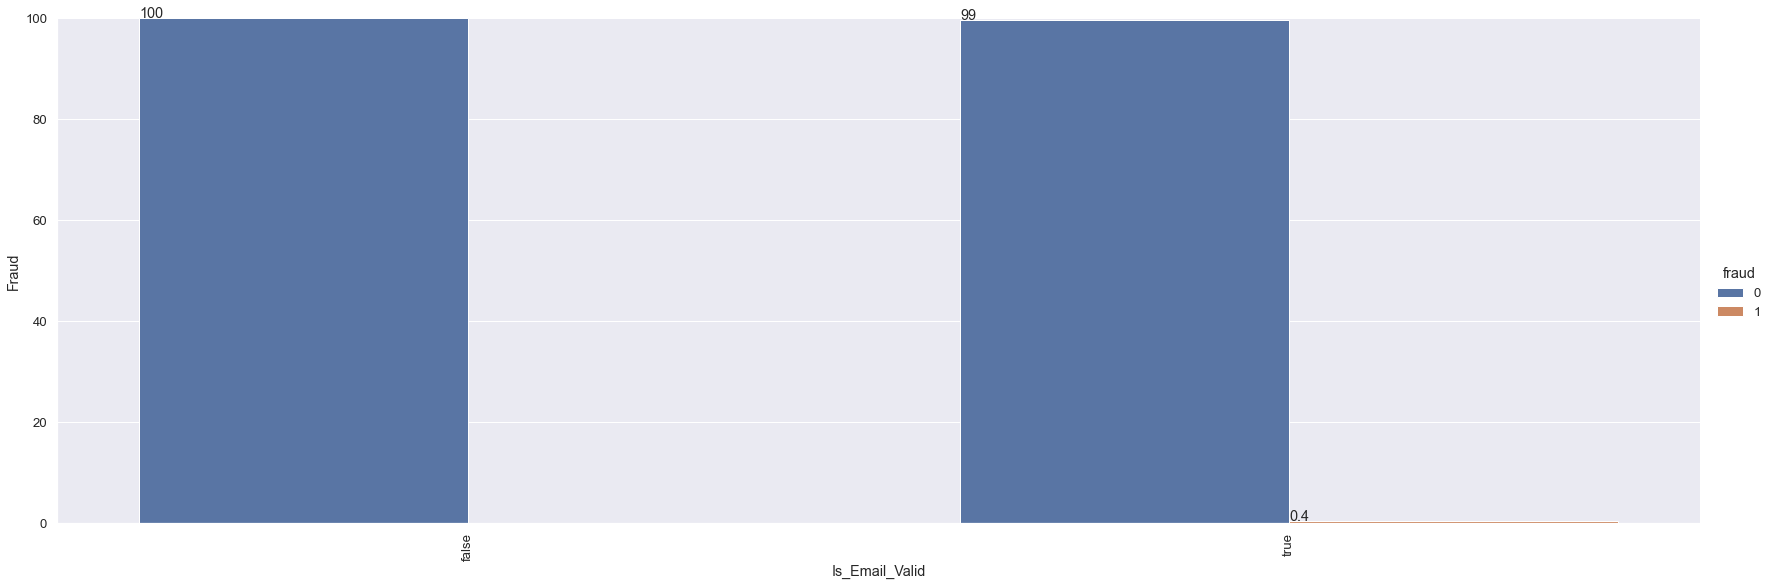

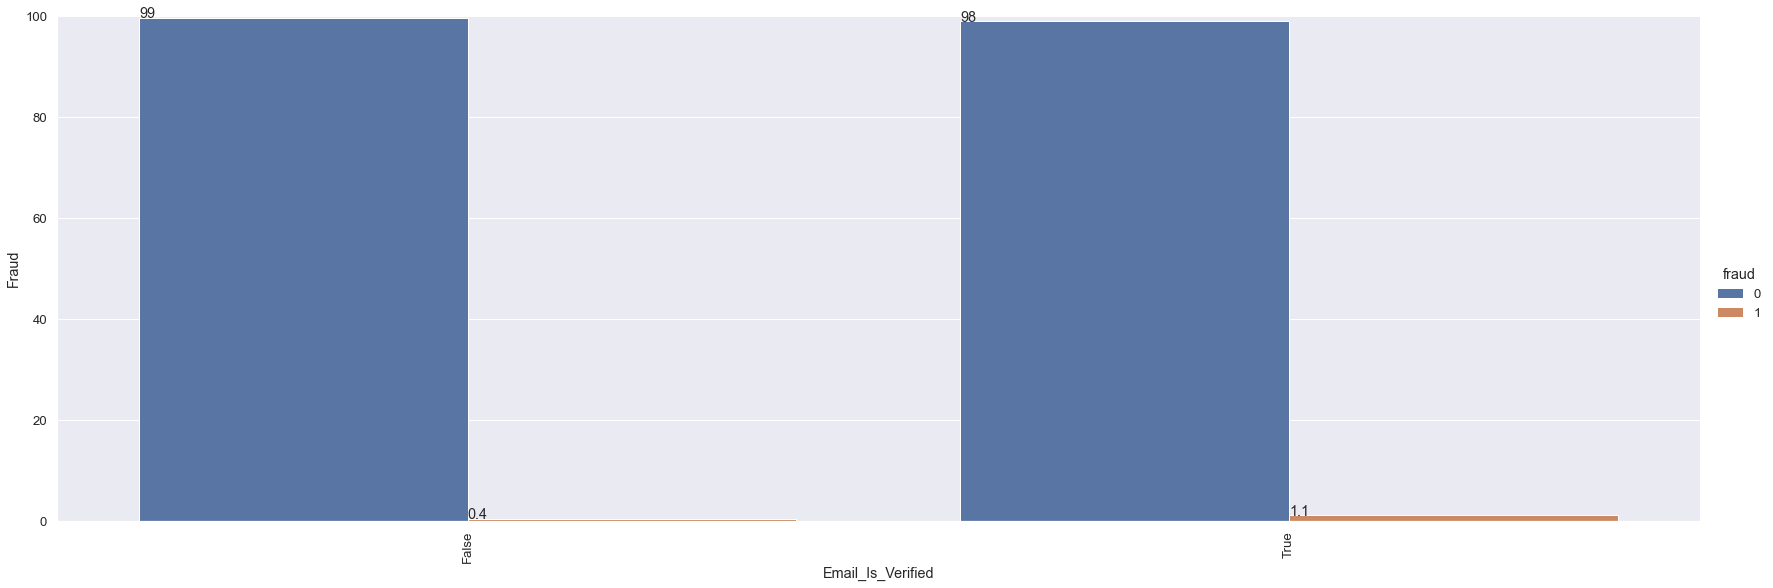

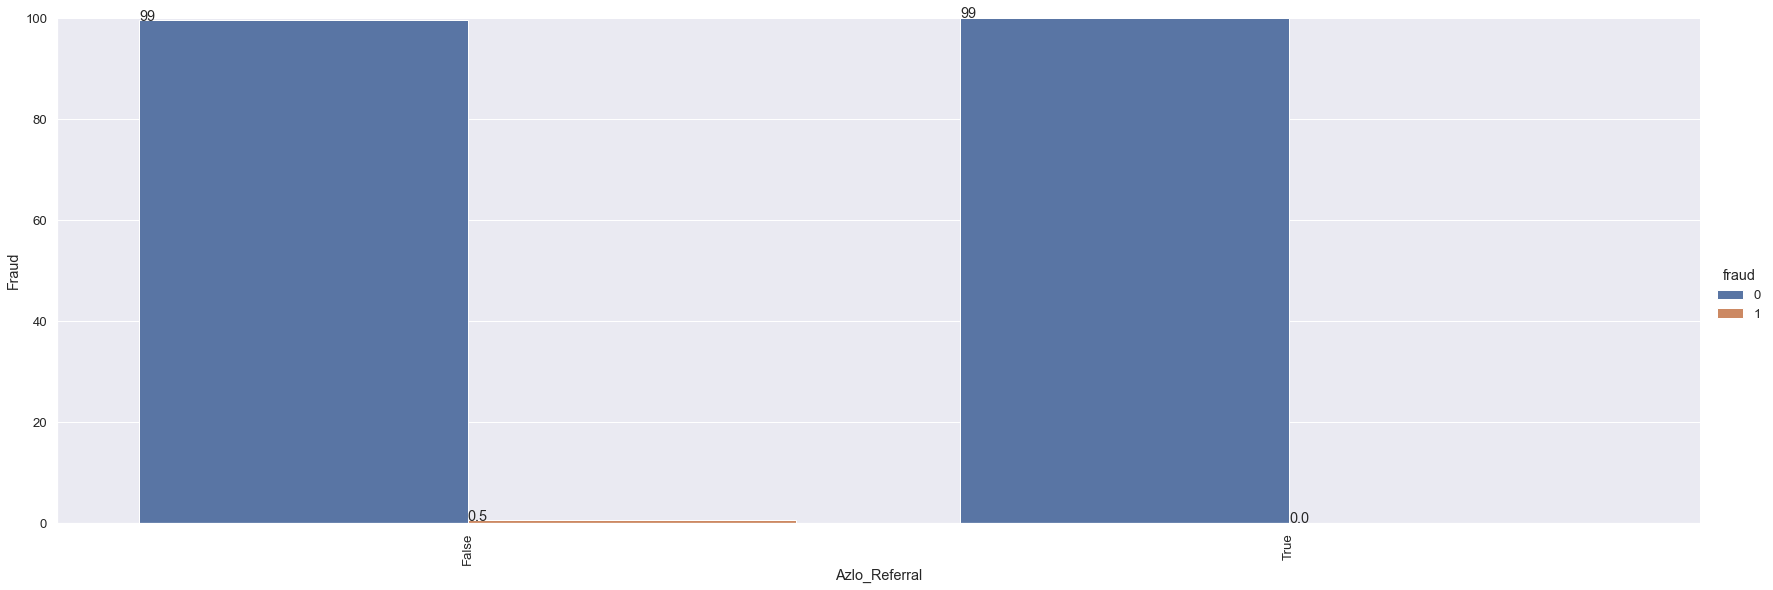

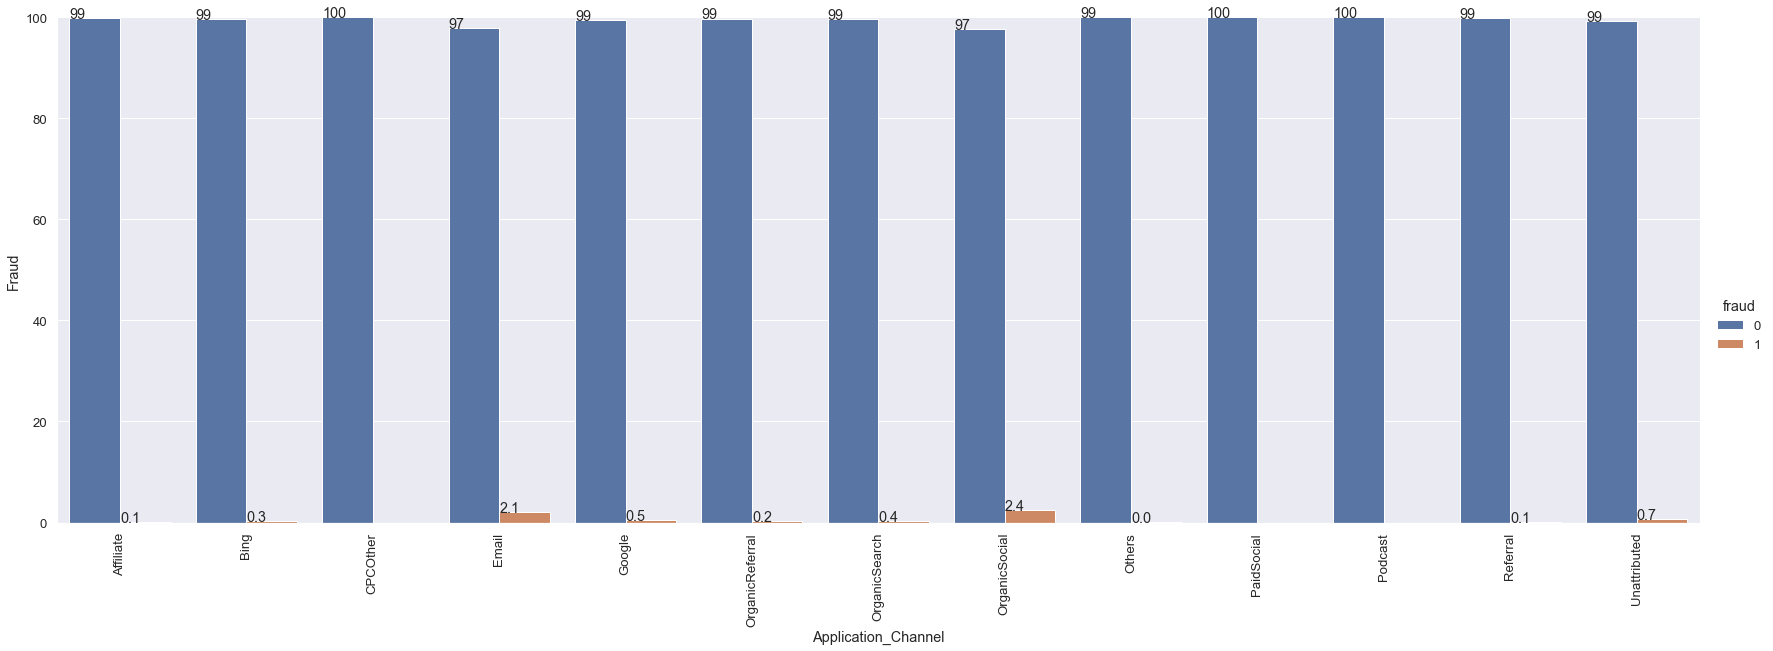

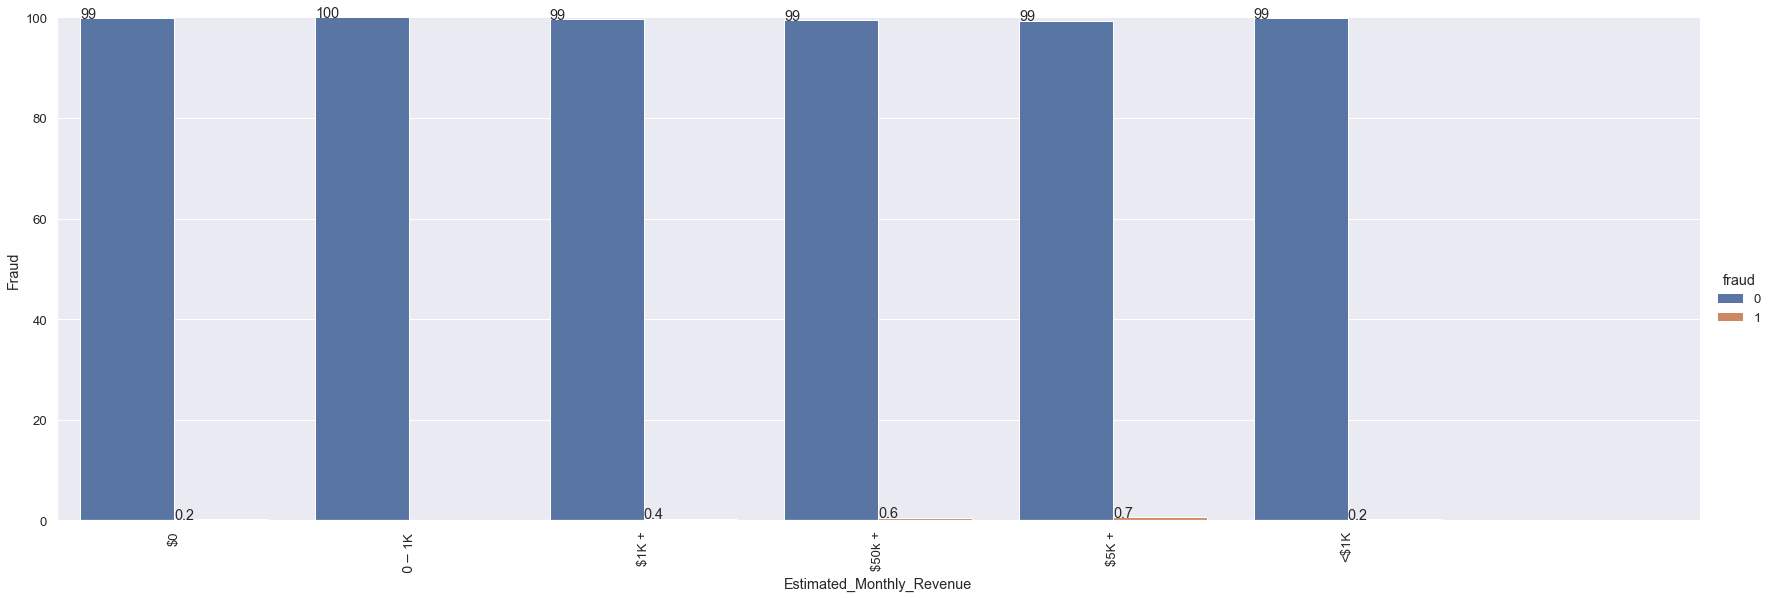

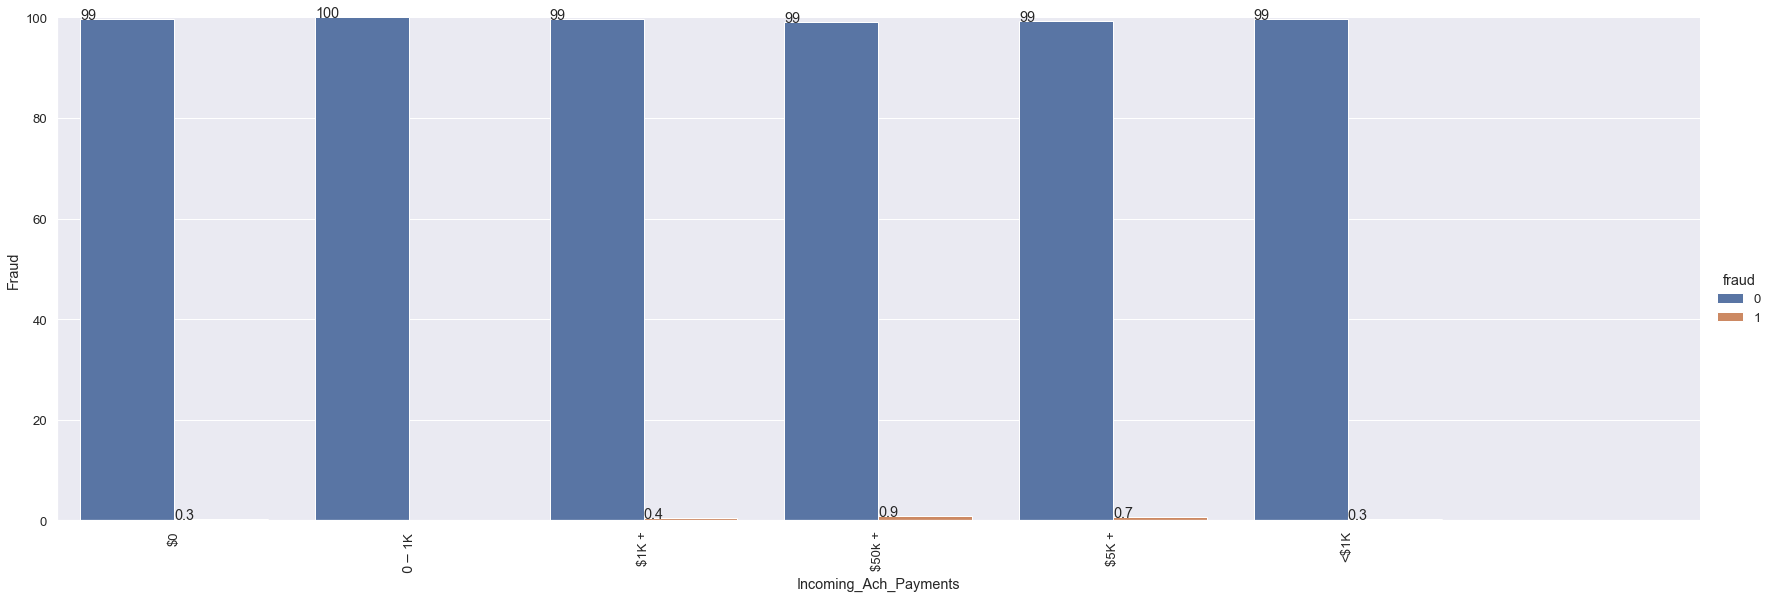

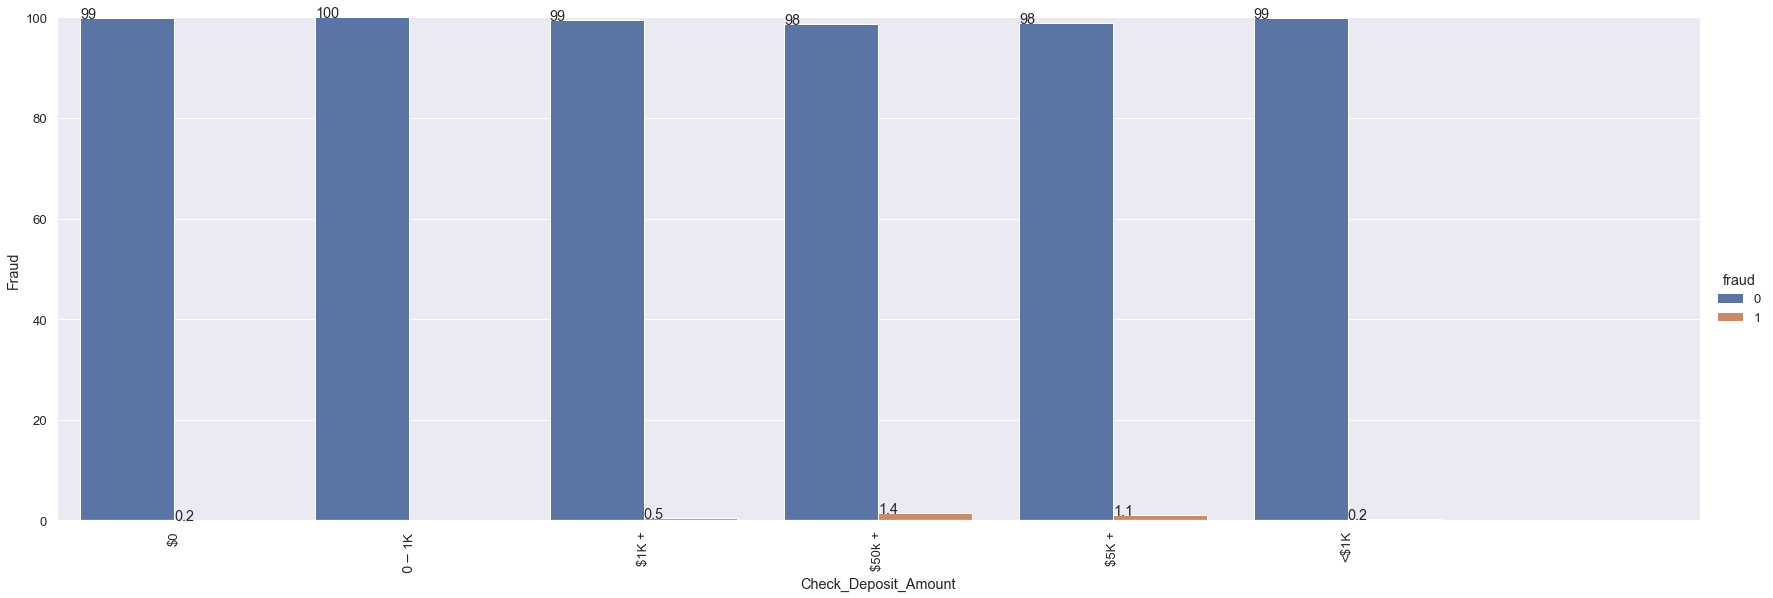

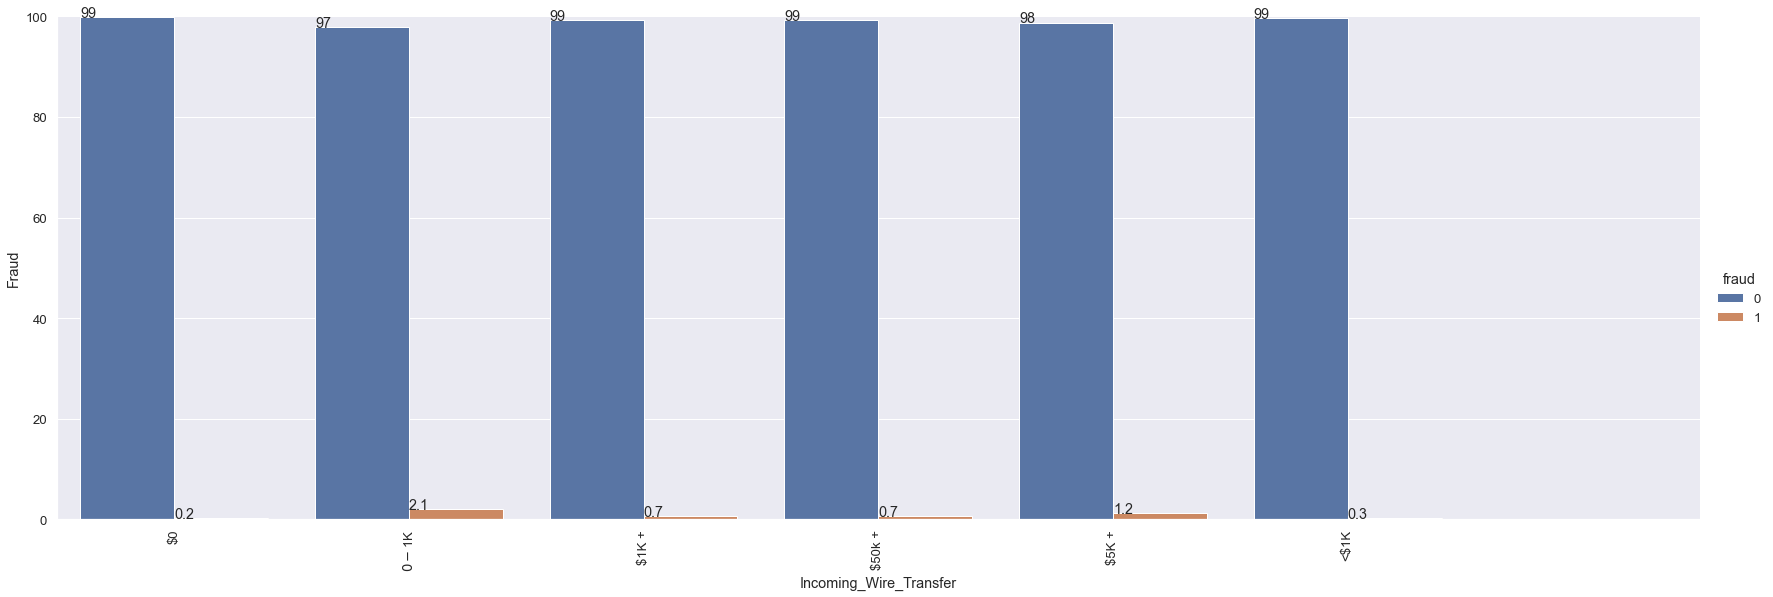

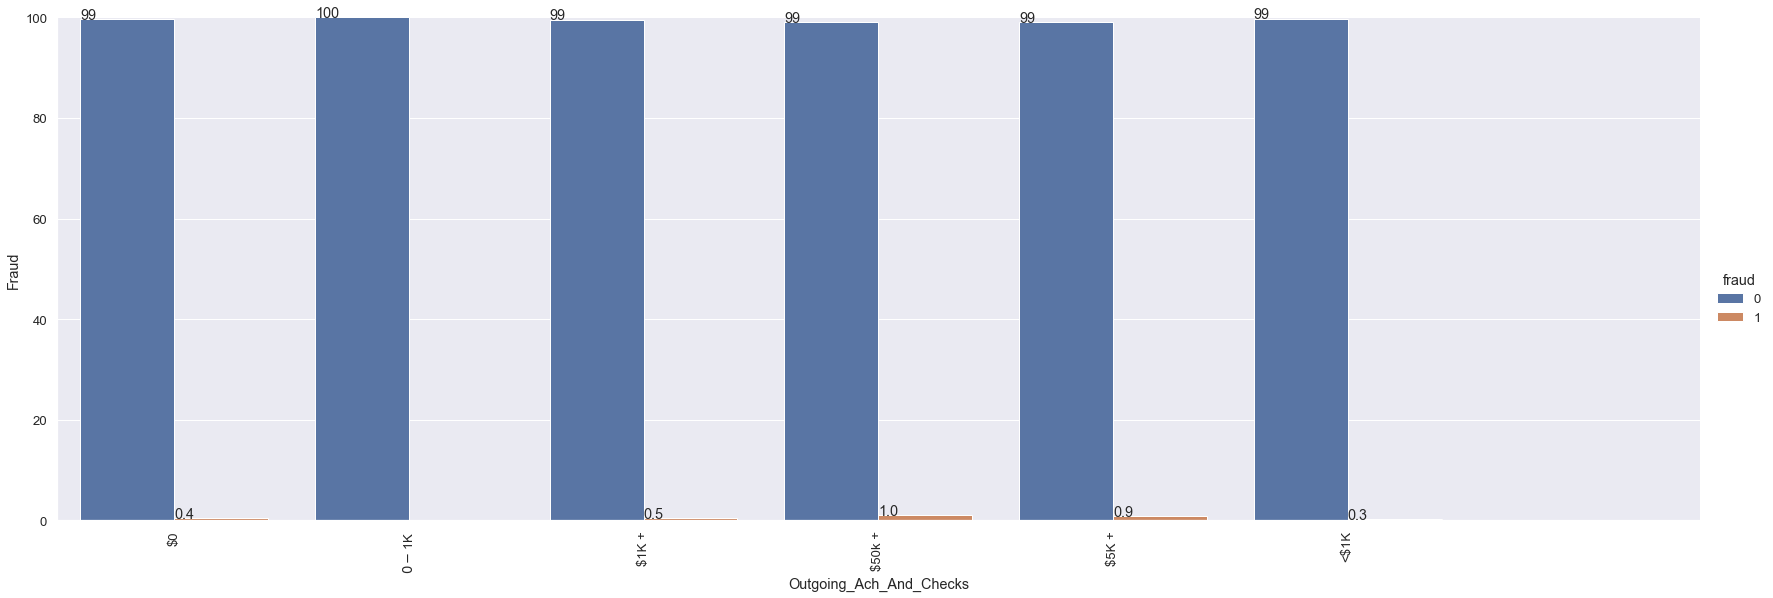

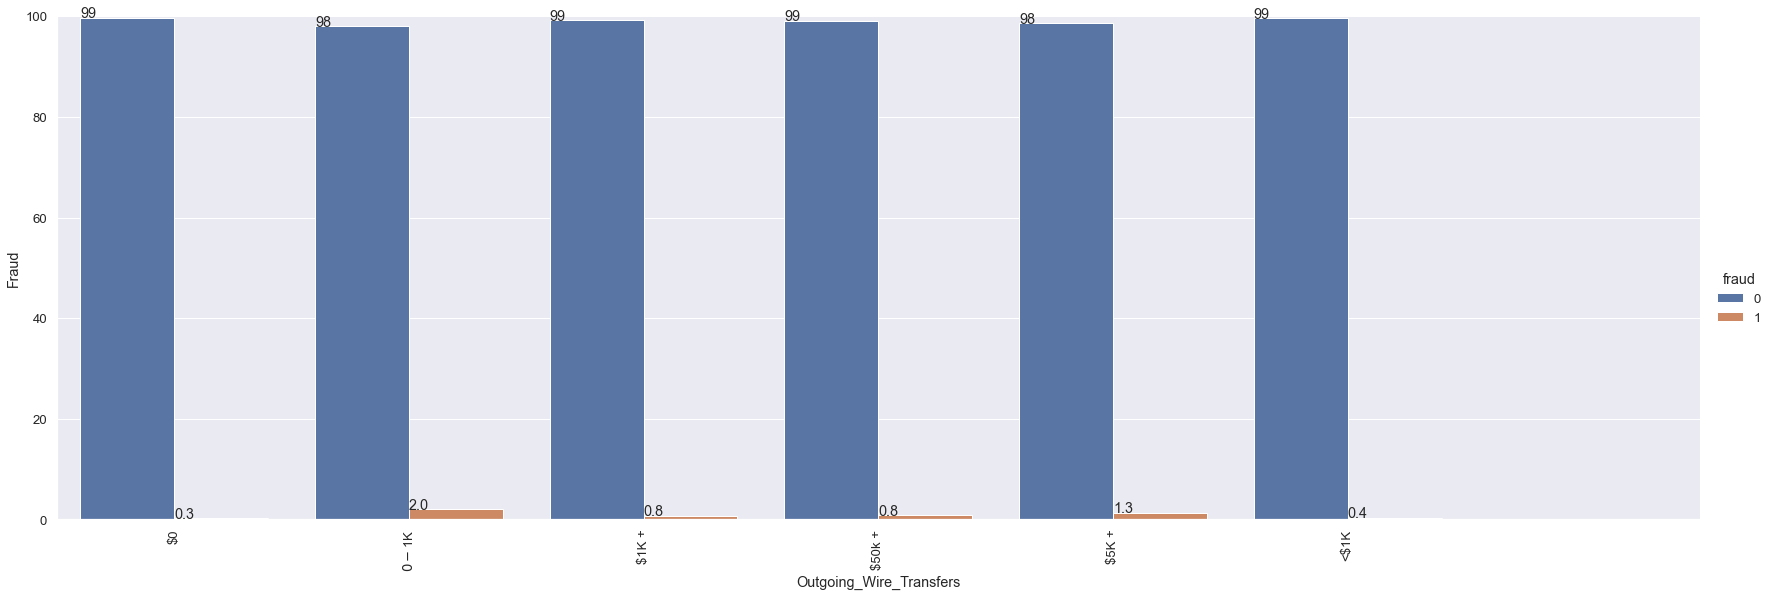

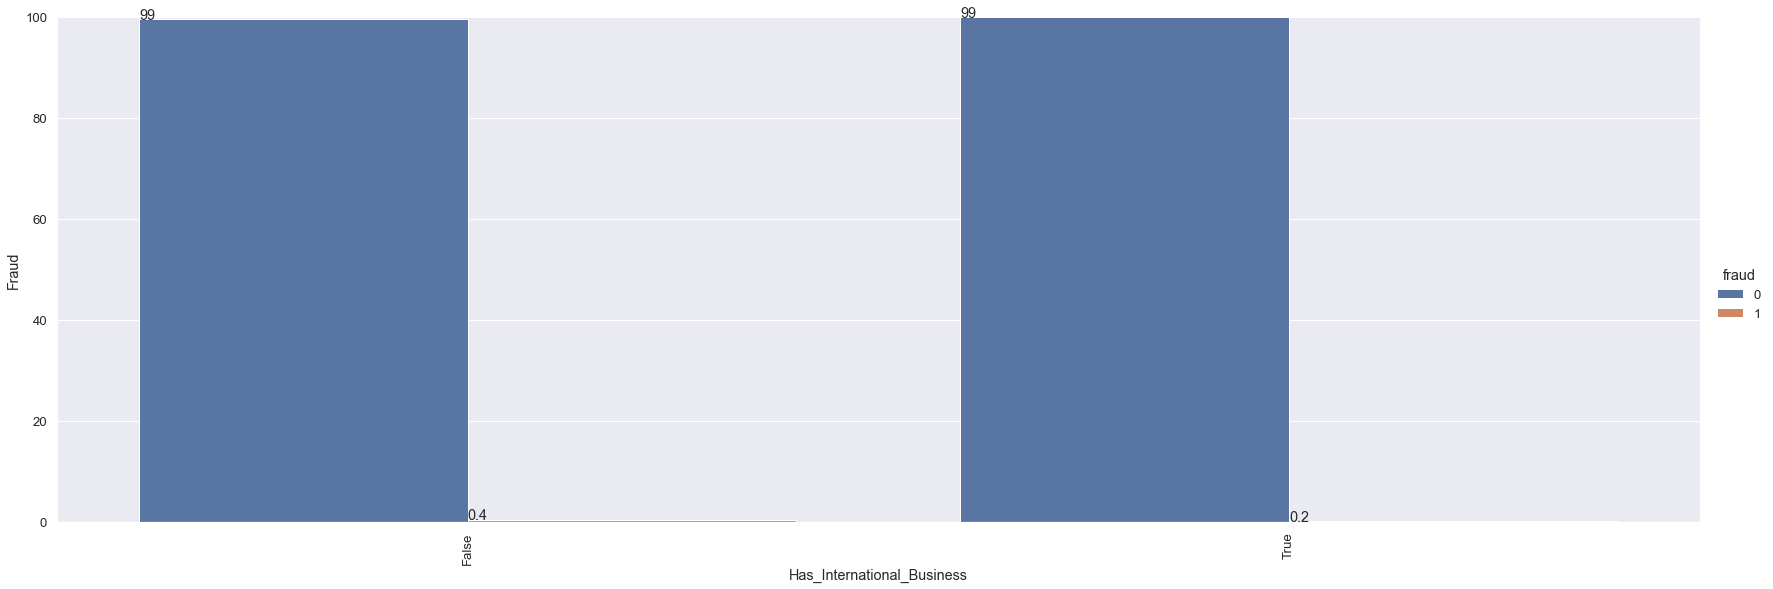

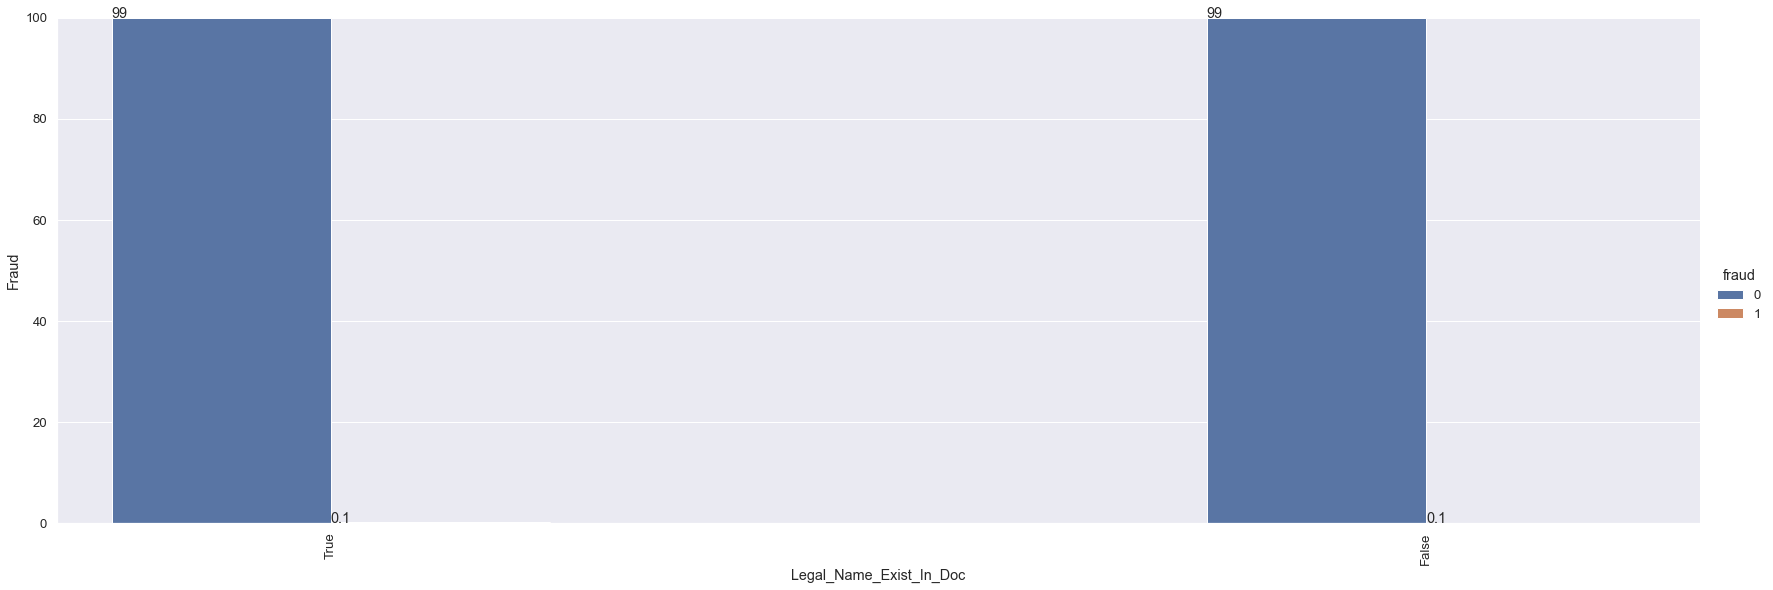

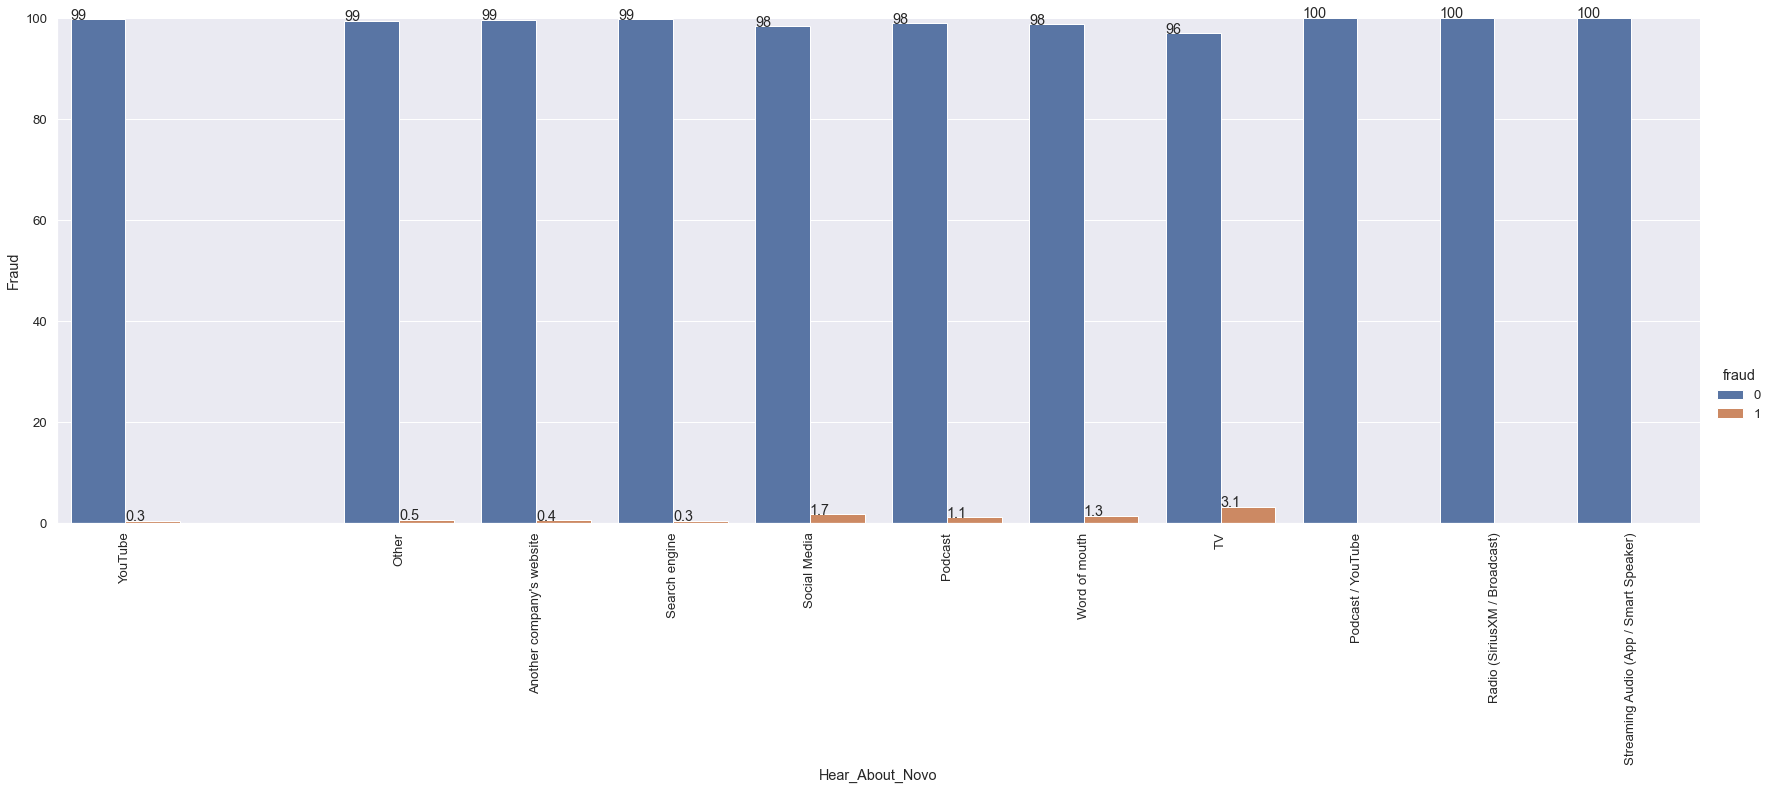

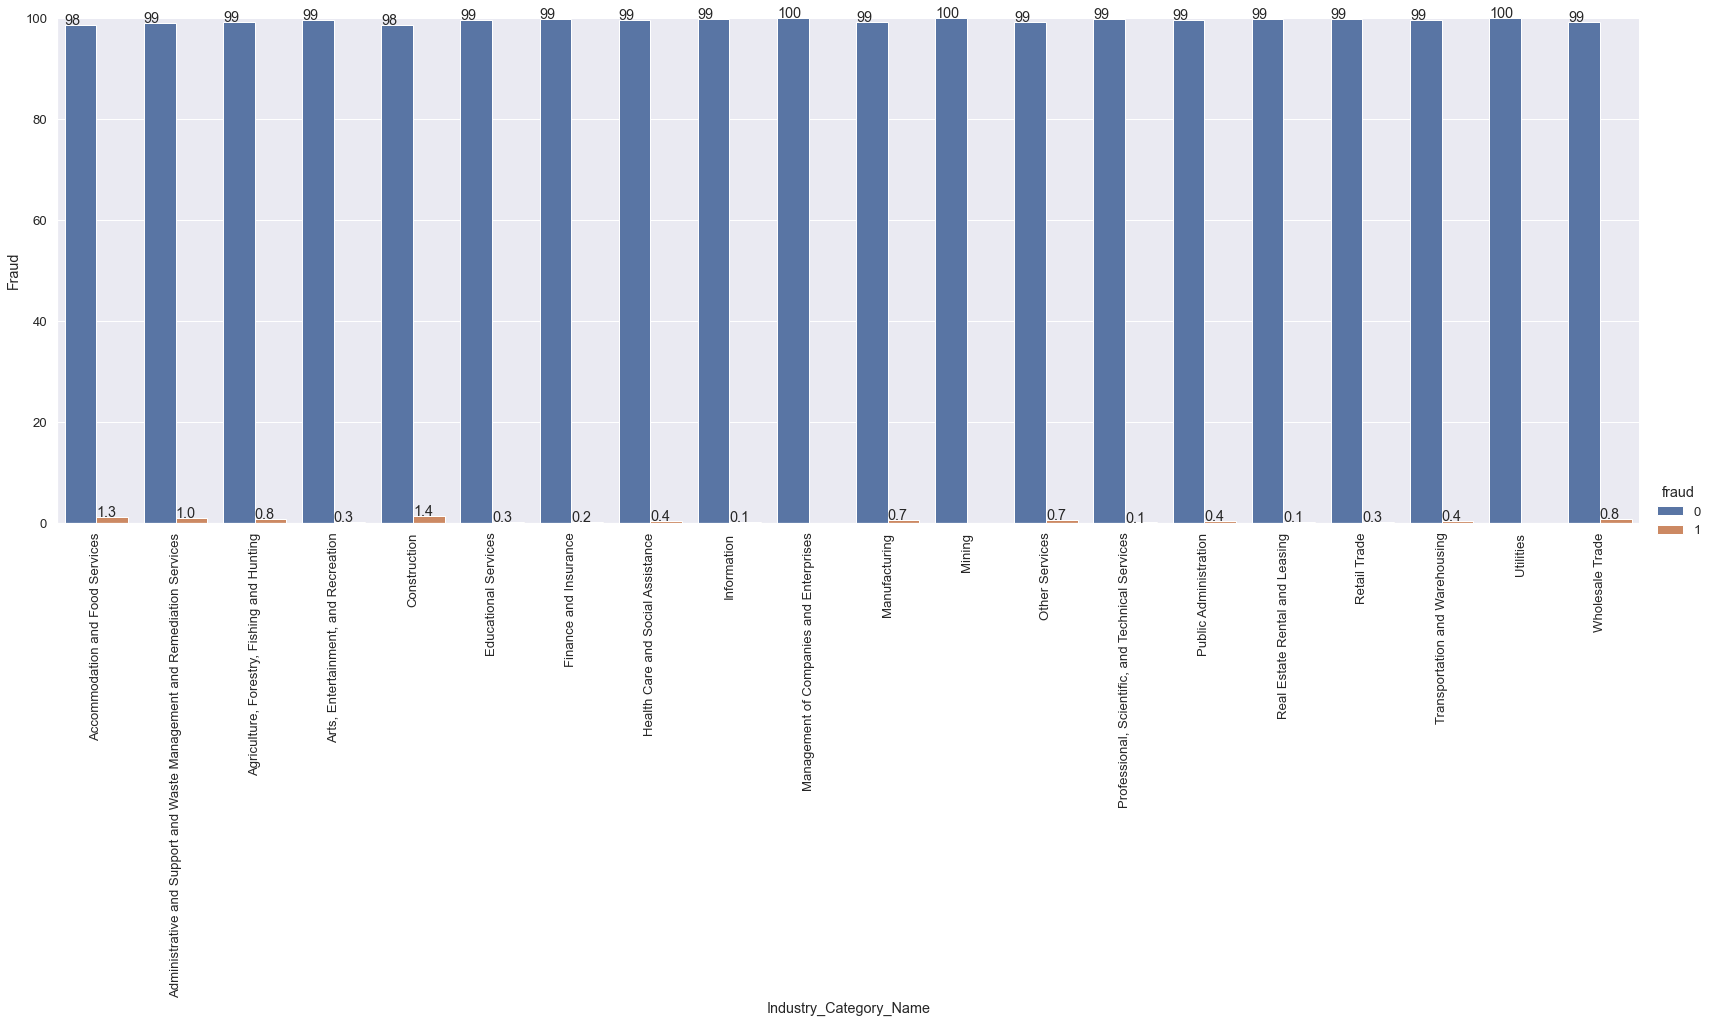

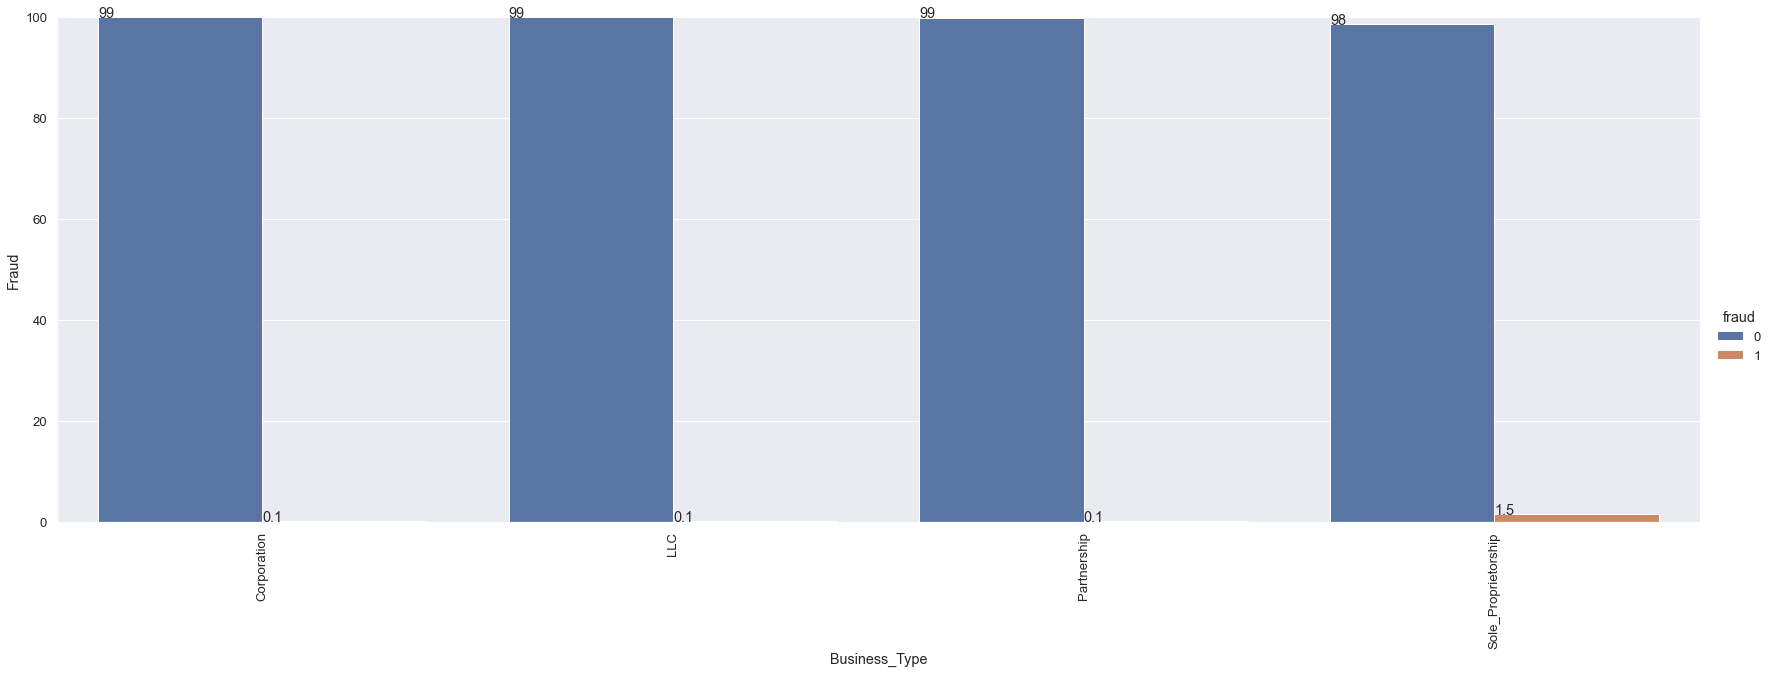

In [277]:
cat_columns = ['is_email_valid','email_is_verified','azlo_referral',
               'application_channel','estimated_monthly_revenue',
               'incoming_ach_payments',
              'check_deposit_amount','incoming_wire_transfer','outgoing_ach_and_checks','outgoing_wire_transfers',
              'has_international_business','legal_name_exist_in_doc','hear_about_novo',
               'industry_category_name','business_type'
              ]
data = fraud_app_data
target = 'fraud'
for i, col in enumerate(cat_columns):
    plotting_percentages(data, col, target)

In [278]:
# Explains better fraud
better_cols = ['azlo_referral','application_channel','has_international_business','hear_about_novo',
              'industry_category_name','business_type']


In [74]:
fraud_app_data.corr()

,fraud,email_is_verified,azlo_referral,number_incomplete_events,aml_risk_score,has_international_business
fraud,1.000000,0.007884,-0.027218,-0.006348,0.080637,-0.009261
email_is_verified,0.007884,1.000000,0.014306,0.047344,-0.027136,0.002424
azlo_referral,-0.027218,0.014306,1.000000,-0.064077,-0.146349,0.033040
number_incomplete_events,-0.006348,0.047344,-0.064077,1.000000,-0.068832,0.018944
aml_risk_score,0.080637,-0.027136,-0.146349,-0.068832,1.000000,0.005522
has_international_business,-0.009261,0.002424,0.033040,0.018944,0.005522,1.000000


### Alloy Persons Features 

In [84]:
# alloy_persons_data = querySno(
# """
# with alloy_persons_data as (
# select distinct
# APPLICATION_ID,
# PERSON_SCORE,
# IDA_SCORE,
# IDA_SCORE_REASON_1,
# IDA_SCORE_REASON_2,
# IDA_SCORE_REASON_3,
# IOVATION_PROXY_IN_USE,
# SENTILINK_ABUSE_SCORE,
# SENTILINK_FIRST_PARTY_SYNTHETIC_SCORE,
# SENTILINK_THIRD_PARTY_SYNTHETIC_SCORE,
# SENTILINK_ID_THEFT_SCORE,
# SOCURE_SIGMA,
# SOCURE_EMAILRISK,
# SOCURE_PHONERISK,
# SOCURE_ADDRESSRISK,
# rank() over(partition by APPLICATION_ID order by APPLICATION_VERSION_ID desc) as ranking
# from prod_db.data.ALLOY_EVALUATIONS_PERSONS
# ),


# apps_data as (
# select
# APPLICATION_ID,
# IS_EMAIL_VALID,
# EMAIL_IS_VERIFIED,
# AZLO_REFERRAL,
# APPLICATION_START_DATETIME,
# APPLICATION_COMPLETE_DATETIME,
# APPLICATION_RESUBMITTED_DATETIME,
# NUMBER_INCOMPLETE_EVENTS,
# AML_RISK_SCORE,
# HIGH_RISK_INDUSTRY,
# UTM_SOURCE,
# UTM_MEDIUM,
# APPLICATION_CHANNEL,
# ESTIMATED_MONTHLY_REVENUE,
# INCOMING_ACH_PAYMENTS,
# CHECK_DEPOSIT_AMOUNT,
# INCOMING_WIRE_TRANSFER,
# OUTGOING_ACH_AND_CHECKS,
# OUTGOING_WIRE_TRANSFERS,
# NUMBER_OF_EMPLOYEES,
# HAS_INTERNATIONAL_BUSINESS,
# LEGAL_NAME_EXIST_IN_DOC,
# HEAR_ABOUT_NOVO,
# INDUSTRY_CATEGORY_ID,
# INDUSTRY_CATEGORY_NAME,
# DATE_OF_ESTABLISHMENT,
# BUSINESS_TYPE
# from prod_db.data.applications 
# where ACCOUNT_OPENED_DATETIME between '2021-01-01' and '2022-02-28'
# ),

# apps_tmp as (
# select * from alloy_persons_data where ranking=1
# ),

# apps as (
# select distinct
# APPLICATION_ID,
# PERSON_SCORE,
# IDA_SCORE,
# IDA_SCORE_REASON_1,
# IDA_SCORE_REASON_2,
# IDA_SCORE_REASON_3,
# IOVATION_PROXY_IN_USE,
# SENTILINK_ABUSE_SCORE,
# SENTILINK_FIRST_PARTY_SYNTHETIC_SCORE,
# SENTILINK_THIRD_PARTY_SYNTHETIC_SCORE,
# SENTILINK_ID_THEFT_SCORE,
# SOCURE_EMAILRISK,
# SOCURE_PHONERISK,
# SOCURE_ADDRESSRISK, first_value(SOCURE_SIGMA) over(partition by APPLICATION_ID order by SOCURE_SIGMA desc) as SOCURE_SIGMA
# from apps_tmp
# ),

# funded_accounts_tmp as (
# select distinct a.BUSINESS_ID, a.APPLICATION_ID, DATEDIFF(day, ACCOUNT_CREATE_DATE, TRANSACTION_DATE) as DAYS_SINCE_CREATED from 
# (
#   select distinct APPLICATION_ID, BUSINESS_ID, ACCOUNT_CREATE_DATE from "PROD_DB"."DATA"."BUSINESSES"
#   where ACCOUNT_CREATE_DATE between '2021-01-01' and '2022-02-28'
# ) a
# inner join
# (
#   select distinct BUSINESS_ID, TRANSACTION_DATE from "PROD_DB"."DATA"."TRANSACTIONS" where type='credit' and status='active'
# ) b
# on a.BUSINESS_ID=b.BUSINESS_ID
# where a.APPLICATION_ID is not null and DAYS_SINCE_CREATED between  0 and 60
# ),

# funded_accounts as (
# select distinct BUSINESS_ID, APPLICATION_ID from funded_accounts_tmp
# ),

# loss_tx as (
#        select *
#         from (
#             select business_id
#             , RANK() OVER (PARTITION BY business_id
#                 ORDER BY transaction_date DESC) returned_rank
#             , amount as loss_tx_amount
#             , created_date loss_tx_created_at
#             , transaction_date loss_tx_transaction_date
#             from prod_db.data.transactions
#             where 1=1
#                 and medium in ('Descriptive Deposit', 'Closeout Withdrawal')
#                 and amount > 0
#                 and running_balance = 0
#         )
#         where returned_rank=1
# ),

# fraud_closure_accounts as (
#     select business_id, closure_reason, business_type, account_close_date, ACCOUNT_CREATE_DATE 
#     ,ACCOUNT_STATUS, CLOSURE_IS_SUSPECT_FRAUD
#     from prod_db.data.businesses 
#     where 1=1
#         and closure_reason ilike '%fraud%' 
#         and account_close_date is not null 
#         and ACCOUNT_CREATE_DATE between '2021-01-01' and '2022-02-28'
#         and account_close_date between '2021-01-01' and '2022-02-28'
# ),

# fraud_acounts_less_60 as (
# select distinct f.business_id, 1 as fraud from (
# select * from fraud_closure_accounts where datediff(day, ACCOUNT_CREATE_DATE, coalesce(account_close_date, current_date())) <= 60
# ) f 
# inner join loss_tx l on f.business_id = l.business_id
# ),

# fraud_acounts_greater_60 as (
# select distinct f.business_id, 1 as fraud from (
# select * from fraud_closure_accounts where datediff(day, ACCOUNT_CREATE_DATE, coalesce(account_close_date, current_date())) > 60
# ) f 
# inner join loss_tx l on f.business_id = l.business_id
# ),

# distinct_app_id_tmp1 as (
# select distinct 
# a.business_id, a.APPLICATION_ID,
# case 
#     when b.fraud=1 then 1
#     else 0
# end as fraud 
# from funded_accounts a
# left join
# fraud_acounts_less_60 b
# on a.business_id=b.business_id
# ),

# distinct_app_id as (
# select a.* from distinct_app_id_tmp1 a
# left join
# fraud_acounts_greater_60 b
# on a.business_id=b.business_id 
# where b.business_id is null
# ),


# apps_new as (
# select a.* from apps a
# inner join
# distinct_app_id b
# on a.APPLICATION_ID=b.APPLICATION_ID
# )

# select distinct * from apps_new
# """
# )

In [85]:
alloy_persons_data.shape

(110237, 15)

In [282]:
alloy_persons_path = '../data/raw/alloy_persons_data.pkl'
# alloy_persons_data.to_pickle(alloy_persons_path)
alloy_persons_data = pd.read_pickle(alloy_persons_path)

In [283]:
len(pd.unique(fraud['application_id'])) - len(pd.unique(fraud_alloy_persons_data['application_id']))
# These 6 applications are not available in alloy persons table

962

In [154]:
fraud_alloy_persons_data = pd.merge(fraud, alloy_persons_data, on='application_id')

print('Shape: ', fraud_alloy_persons_data.shape)
print('\n',fraud_alloy_persons_data['fraud'].value_counts())

Shape:  (110237, 17)

 0    109766
1       471
Name: fraud, dtype: int64


In [155]:
fraud_alloy_persons_data.drop('sentilink_id_theft_score', inplace=True, axis=1)

In [157]:
fraud_alloy_persons_data.dropna(how='any',axis=0, inplace=True)
fraud_alloy_persons_data['fraud'].value_counts()

0    108816
1       465
Name: fraud, dtype: int64

In [159]:
fraud_alloy_persons_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109281 entries, 0 to 110236
Data columns (total 16 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   business_id                            109281 non-null  object 
 1   application_id                         109281 non-null  object 
 2   fraud                                  109281 non-null  int64  
 3   person_score                           109281 non-null  float64
 4   ida_score                              109281 non-null  float64
 5   ida_score_reason_1                     109281 non-null  float64
 6   ida_score_reason_2                     109281 non-null  float64
 7   ida_score_reason_3                     109281 non-null  float64
 8   iovation_proxy_in_use                  109281 non-null  object 
 9   sentilink_abuse_score                  109281 non-null  float64
 10  sentilink_first_party_synthetic_score  109281 non-null  

In [160]:
fraud_alloy_persons_data.describe()

,fraud,person_score,ida_score,ida_score_reason_1,ida_score_reason_2,ida_score_reason_3,sentilink_abuse_score,sentilink_first_party_synthetic_score,sentilink_third_party_synthetic_score,socure_emailrisk,socure_phonerisk,socure_addressrisk,socure_sigma
count,109281.000000,109281.000000,109281.000000,109281.000000,109281.000000,109281.000000,109281.000000,109281.000000,109281.000000,109281.000000,109281.000000,109281.000000,109281.000000
mean,0.004255,0.832750,561.637641,809.985130,854.182960,915.059553,53.535894,56.323377,56.737393,0.726213,0.396405,0.417278,0.623929
std,0.065092,0.090698,100.598799,211.358097,160.230314,123.968507,64.817441,69.049747,70.667301,0.278054,0.254635,0.295952,0.279569
min,0.000000,0.050000,233.000000,18.000000,153.000000,153.000000,10.000000,10.000000,10.000000,0.001000,0.001000,0.001000,0.001000
25%,0.000000,0.780000,493.000000,628.000000,675.000000,909.000000,24.000000,27.000000,28.000000,0.553000,0.193000,0.152000,0.399000
50%,0.000000,0.870000,556.000000,963.000000,909.000000,963.000000,38.000000,39.000000,41.000000,0.864000,0.349000,0.380000,0.692000
75%,0.000000,0.870000,626.000000,992.000000,963.000000,992.000000,63.000000,63.000000,65.000000,0.931000,0.574000,0.671000,0.866000
max,1.000000,1.000000,989.000000,994.000000,994.000000,994.000000,748.000000,914.000000,882.000000,0.999000,0.999000,0.999000,0.999000


In [161]:
for i, value in enumerate(fraud_alloy_persons_data.columns):
    try: 
        print(value, ': ', len(np.unique(list(fraud_alloy_persons_data[value]))))
    except:
        print(value, ': ', "Error")

business_id :  109281
application_id :  109281
fraud :  2
person_score :  89
ida_score :  694
ida_score_reason_1 :  41
ida_score_reason_2 :  50
ida_score_reason_3 :  49
iovation_proxy_in_use :  2
sentilink_abuse_score :  677
sentilink_first_party_synthetic_score :  711
sentilink_third_party_synthetic_score :  750
socure_emailrisk :  999
socure_phonerisk :  997
socure_addressrisk :  989
socure_sigma :  999


In [164]:
fraud_alloy_persons_data.person_score.value_counts()
# upto 0.85 and above 0.85

0.87    36227
0.81    10899
0.76     9282
0.91     6547
0.70     5785
        ...  
0.05        1
0.19        1
0.25        1
0.22        1
0.13        1
Name: person_score, Length: 89, dtype: int64

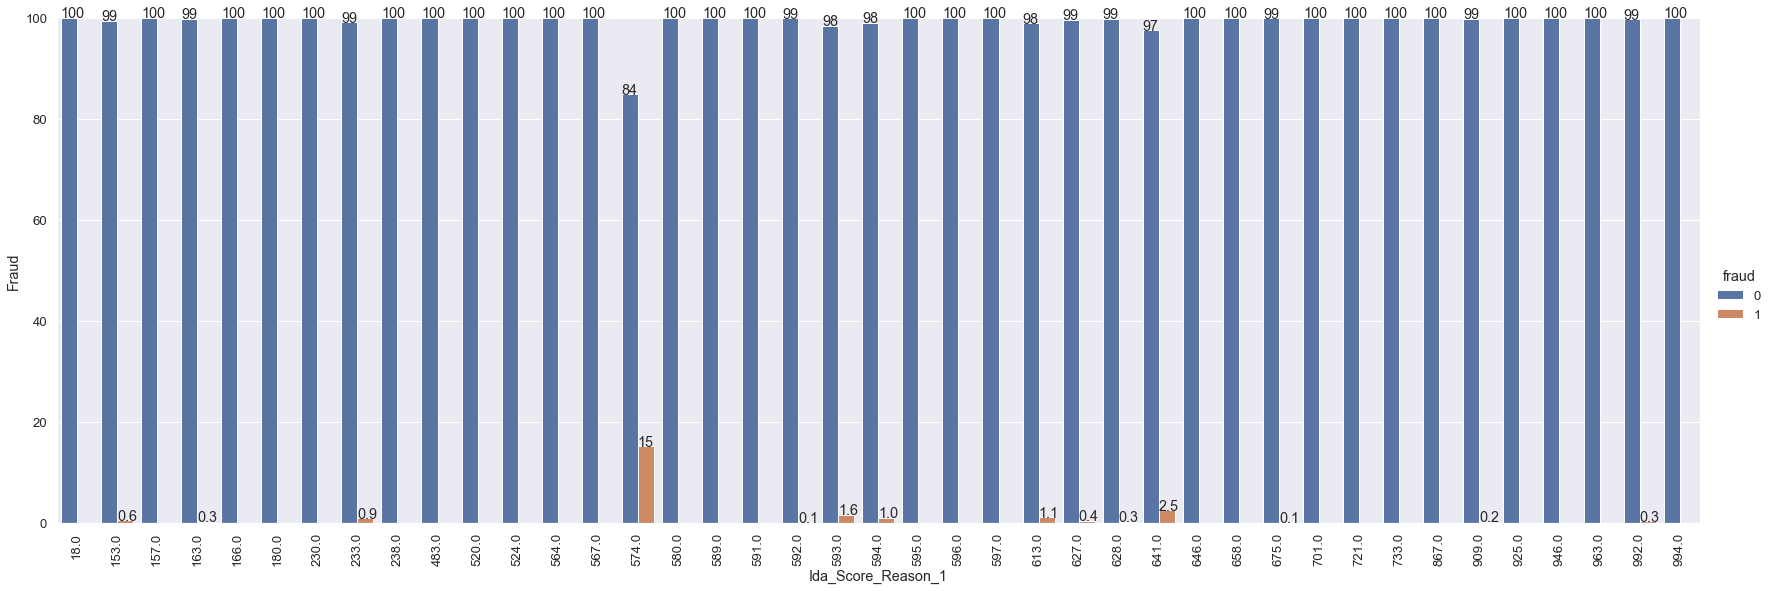

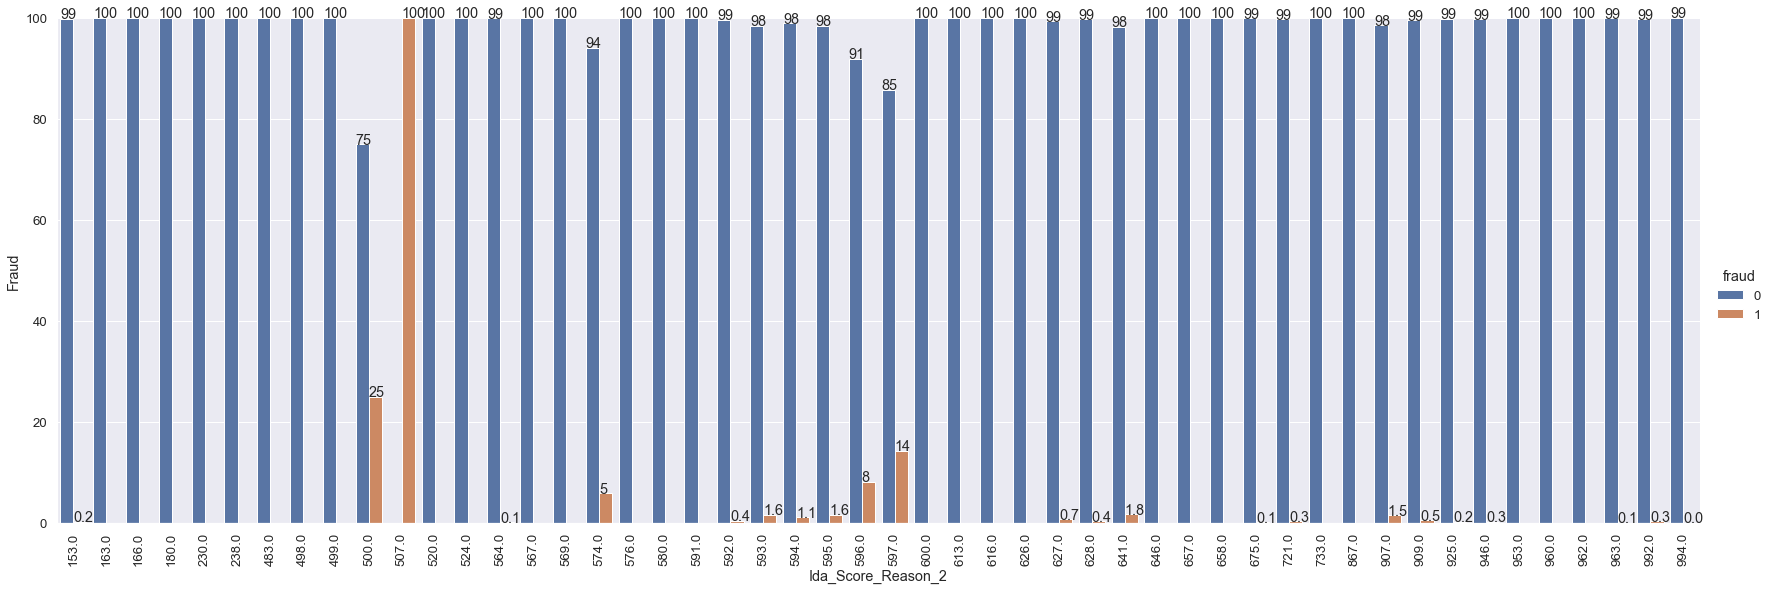

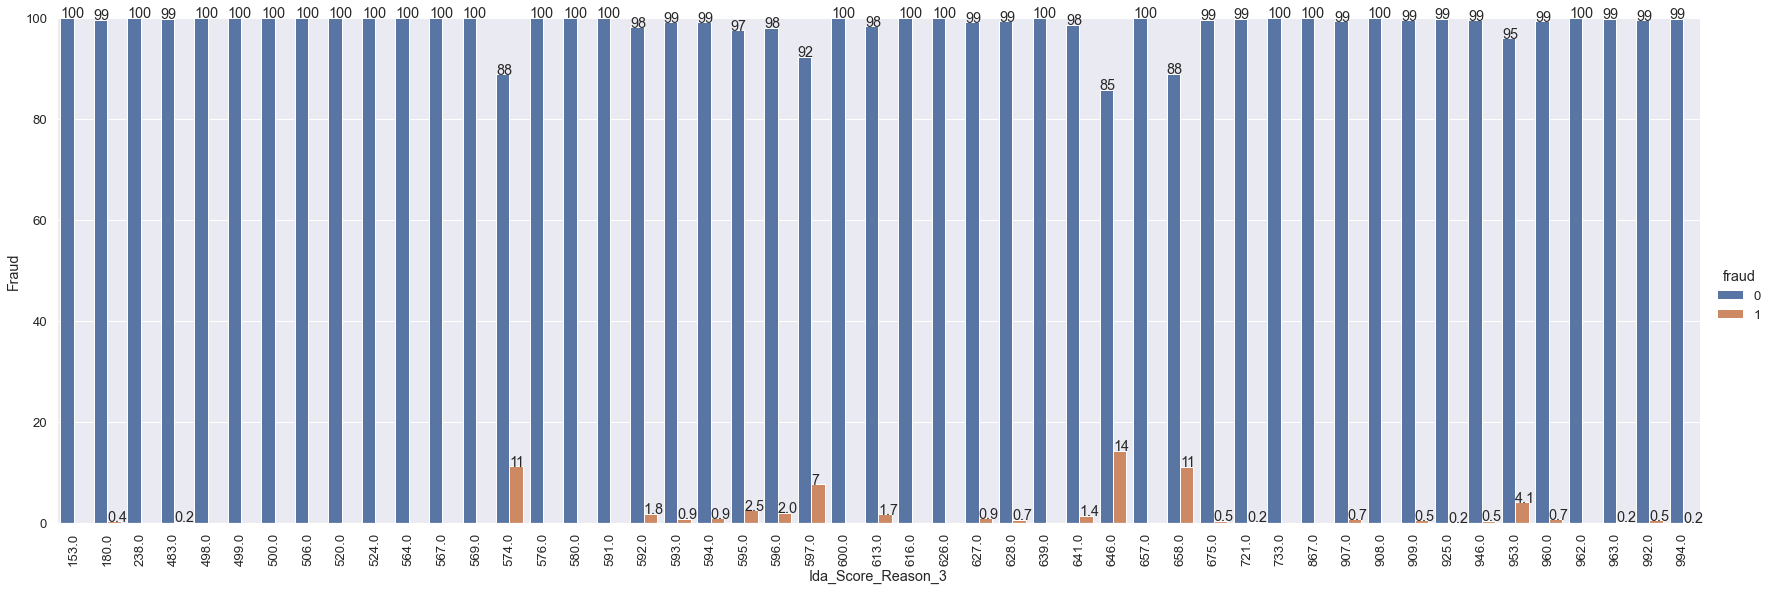

In [279]:
cat_columns = ['ida_score_reason_1', 'ida_score_reason_2', 'ida_score_reason_3']
target = 'fraud'
data = fraud_alloy_persons_data

for i, col in enumerate(cat_columns):
    plotting_percentages(data, col, target)

In [91]:
fraud_alloy_persons_data.corr()

,fraud,person_score,ida_score,ida_score_reason_1,ida_score_reason_2,ida_score_reason_3,sentilink_abuse_score,sentilink_first_party_synthetic_score,sentilink_third_party_synthetic_score,sentilink_id_theft_score,socure_emailrisk,socure_phonerisk,socure_addressrisk,socure_sigma
fraud,1.000000,-0.002184,0.024830,-0.019563,-0.025739,-0.027248,0.003707,0.008984,-0.002204,0.023937,-0.026457,0.048086,0.011024,-0.008102
person_score,-0.002184,1.000000,-0.338694,0.260374,0.235565,0.223057,-0.194002,-0.154048,-0.193406,-0.383303,-0.439403,-0.447045,-0.282804,-0.462151
ida_score,0.024830,-0.338694,1.000000,-0.707088,-0.687502,-0.589672,0.036648,0.058047,-0.013020,0.326901,0.288175,0.269668,0.252088,0.394836
ida_score_reason_1,-0.019563,0.260374,-0.707088,1.000000,0.585602,0.410159,-0.054712,-0.061019,-0.016596,-0.251088,-0.154549,-0.205177,-0.235444,-0.267751
ida_score_reason_2,-0.025739,0.235565,-0.687502,0.585602,1.000000,0.476003,-0.035164,-0.046870,-0.000919,-0.263842,-0.125791,-0.234149,-0.214613,-0.248561
ida_score_reason_3,-0.027248,0.223057,-0.589672,0.410159,0.476003,1.000000,-0.035107,-0.049801,0.000217,-0.256826,-0.090464,-0.248739,-0.207763,-0.216016
sentilink_abuse_score,0.003707,-0.194002,0.036648,-0.054712,-0.035164,-0.035107,1.000000,0.793434,0.782704,0.018621,0.027863,0.101487,0.059176,0.055775
sentilink_first_party_synthetic_score,0.008984,-0.154048,0.058047,-0.061019,-0.046870,-0.049801,0.793434,1.000000,0.457504,0.031328,0.019661,0.078073,0.046455,0.045769
sentilink_third_party_synthetic_score,-0.002204,-0.193406,-0.013020,-0.016596,-0.000919,0.000217,0.782704,0.457504,1.000000,-0.023036,0.044863,0.093787,0.063325,0.058251
sentilink_id_theft_score,0.023937,-0.383303,0.326901,-0.251088,-0.263842,-0.256826,0.018621,0.031328,-0.023036,1.000000,0.144233,0.392786,0.150657,0.319263


### APPENDIX 

__Data Information__
- Total accounts created between 2021-01-01 and 2022-02-28 : 144,067
    - Total accounts closed: 16,208 (11%)
        - Total accounts fraud: 4,649 (29%)
            - Total accounts fraud with loss: 960 (21%)
                - Total accounts fraud with loss within 60 days: 471 (49%)


### Code snippets

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]),
 [Text(0, 0, '153.0'),
  Text(1, 0, '180.0'),
  Text(2, 0, '238.0'),
  Text(3, 0, '483.0'),
  Text(4, 0, '498.0'),
  Text(5, 0, '499.0'),
  Text(6, 0, '500.0'),
  Text(7, 0, '506.0'),
  Text(8, 0, '520.0'),
  Text(9, 0, '524.0'),
  Text(10, 0, '564.0'),
  Text(11, 0, '567.0'),
  Text(12, 0, '569.0'),
  Text(13, 0, '574.0'),
  Text(14, 0, '576.0'),
  Text(15, 0, '580.0'),
  Text(16, 0, '591.0'),
  Text(17, 0, '592.0'),
  Text(18, 0, '593.0'),
  Text(19, 0, '594.0'),
  Text(20, 0, '595.0'),
  Text(21, 0, '596.0'),
  Text(22, 0, '597.0'),
  Text(23, 0, '600.0'),
  Text(24, 0, '613.0'),
  Text(25, 0, '616.0'),
  Text(26, 0, '626.0'),
  Text(27, 0, '627.0'),
  Text(28, 0, '628.0'),
  Text(29, 0, '639.0'),
  Text(30, 0, '641.0'),
  Text(31, 0, '646.0'),
  Text(32, 0, '657.0

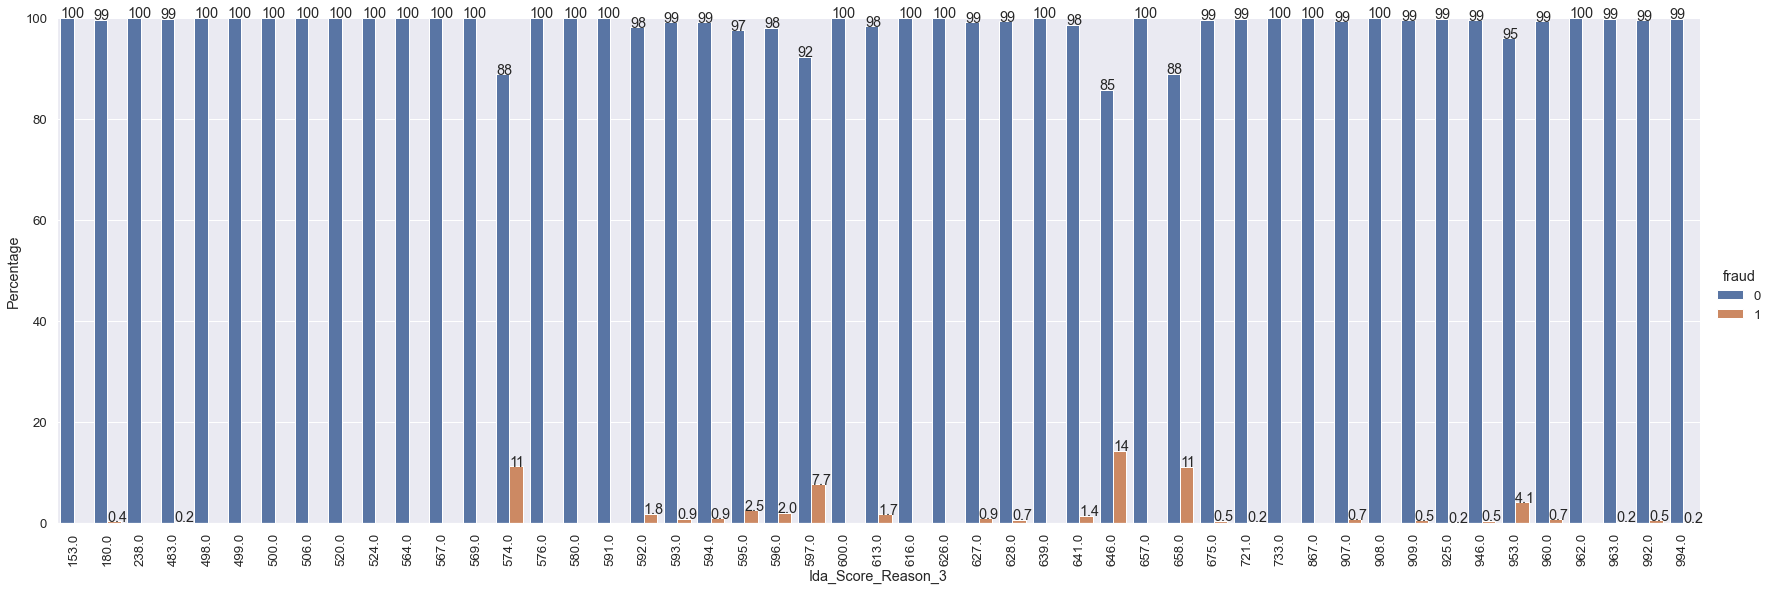

In [281]:
cat_columns = 'ida_score_reason_2'
target = 'fraud'
data = fraud_alloy_persons_data
df = data

x, y = col, target
    
# Temporary dataframe with percentage values
temp_df = df.groupby(x)[y].value_counts(normalize=True)
temp_df = temp_df.mul(100).rename('percent').reset_index()

# Sort the column values for plotting    
order_list = list(df[col].unique())
try:
    order_list.sort()
except:
    order_list = order_list

# Plot the figure
sns.set(font_scale=1.2)
g = sns.catplot(x=x, y='percent', hue=y,kind='bar', data=temp_df, 
                height=8, aspect=3, order=order_list, legend_out=True)
g.ax.set_ylim(0,100)

# ax.bar_label(x, padding=3, rotation=90)
# ax.bar_label(y, padding=3, rotation=90)


# Loop through each bar in the graph and add the percentage value    
for p in g.ax.patches:
    if math.isnan(p.get_height())==False:
        if p.get_height() < 10:
            txt = str(p.get_height().round(1))
            txt_x = p.get_x() 
            txt_y = p.get_height()
            g.ax.text(txt_x,txt_y,txt)
        else:
            txt = str(int(p.get_height()))
            txt_x = p.get_x() 
            txt_y = p.get_height()
            g.ax.text(txt_x,txt_y,txt)
            
plt.xlabel(col.title())
plt.ylabel('Percentage')
plt.xticks(rotation=90)

In [ ]:
# for i, col in enumerate(cat_columns):
#     plt.figure()
#     ax = sns.countplot(x=col, hue='fraud', data = fraud_app_data)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
#     for bars in ax.containers:
#         ax.bar_label(bars, fmt='%.0f')
#     plt.legend(loc='upper right')


In [73]:
# for i, col in enumerate(cat_columns): 
#     print(fraud_app_data.groupby([col],as_index=False).agg({'fraud':np.mean}), "\n\n")
